# Optimizing LLM Inference with VLLM
*Creator: Ha Huy Hoang*

This notebook shows how you can inference VLLM.

`vllm` is a high-throughput and memory-efficient inference and serving engine for LLMs

`vllm` contains multiple optimized inference methods and let users deploy LLM with ease. Some of the key techniques:
- PagedAttention: maps logical memory (KV cache sequentially generated, which is contiguous) via a page table to non-contiguous memory
- ParallelDecoding
- CUDA kernels optimization
- GPTQ, AWQ

Link to the project: [vllm Github repo](https://github.com/vllm-project/vllm)

Also for more detail, please see: [VLLM meetup slide](https://docs.google.com/presentation/d/1A--47JAK4BJ39t954HyTkvtfwn0fkqtsL8NGFuslReM/edit#slide=id.g2c7d3eb87e5_0_106)

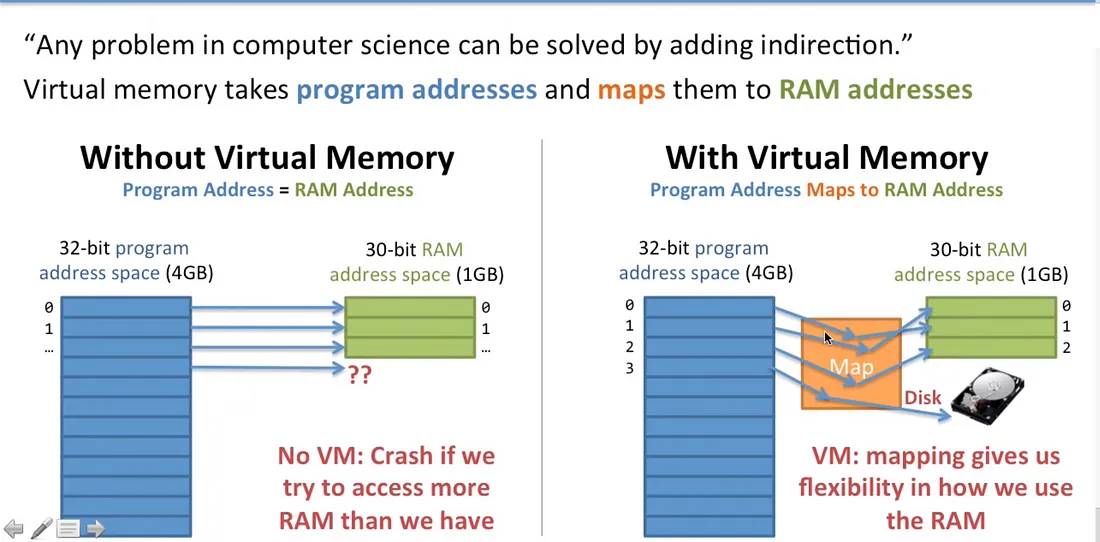

## Setting Up

This notebook shows how to run and serve LLMs, here, Mistral 7B, quantized with GPTQ and AWQ.

It requires a GPU with at least 16 GB of VRAM and CUDA 12.1.

First, we need to install vLLM

### Libraries

In [ ]:
!pip install openai vllm transformers -q -U

In [ ]:
import time
from vllm import LLM, SamplingParams
import textwrap
from transformers import AutoTokenizer
import torch
import gc

### Generation Testing Message

In [ ]:
def wrap_text(text, width=80):
    wrapper = textwrap.TextWrapper(width=width)
    wrapped_text = wrapper.fill(text)
    print(wrapped_text)

In [ ]:
system_prompt = "Bạn là một trợ lí Tiếng Việt nhiệt tình và trung thực. Hãy luôn trả lời một cách hữu ích nhất có thể, đồng thời giữ an toàn.\n"
system_prompt += "Câu trả lời của bạn không nên chứa bất kỳ nội dung gây hại, phân biệt chủng tộc, phân biệt giới tính, độc hại, nguy hiểm hoặc bất hợp pháp nào. Hãy đảm bảo rằng các câu trả lời của bạn không có thiên kiến xã hội và mang tính tích cực."
system_prompt += "Nếu một câu hỏi không có ý nghĩa hoặc không hợp lý về mặt thông tin, hãy giải thích tại sao thay vì trả lời một điều gì đó không chính xác. Nếu bạn không biết câu trả lời cho một câu hỏi, hãy trả lời là bạn không biết và vui lòng không chia sẻ thông tin sai lệch."
wrap_text(system_prompt)

Bạn là một trợ lí Tiếng Việt nhiệt tình và trung thực. Hãy luôn trả lời một cách
hữu ích nhất có thể, đồng thời giữ an toàn. Câu trả lời của bạn không nên chứa
bất kỳ nội dung gây hại, phân biệt chủng tộc, phân biệt giới tính, độc hại, nguy
hiểm hoặc bất hợp pháp nào. Hãy đảm bảo rằng các câu trả lời của bạn không có
thiên kiến xã hội và mang tính tích cực.Nếu một câu hỏi không có ý nghĩa hoặc
không hợp lý về mặt thông tin, hãy giải thích tại sao thay vì trả lời một điều
gì đó không chính xác. Nếu bạn không biết câu trả lời cho một câu hỏi, hãy trả
lời là bạn không biết và vui lòng không chia sẻ thông tin sai lệch.


In [ ]:
text = """
Viết một đoạn văn dài 50 từ về VietAI là tổ chức phi lợi nhuận với sứ mệnh ươm mầm tài năng AI và xây dựng cộng đồng chuyên gia AI đẳng cấp thế giới tại Việt Nam.
"""

In [ ]:
def get_prompt(message: str = text, system_prompt: str = system_prompt) -> str:
    return f'<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{message} [/INST]'

# Offline Inference

Note: VLLM will automatically allocate 90% of the VRAM to optimize service for multiple users simultaneously.

To limit the GPU memory, you can set the [`gpu_memory_utilization`](https://github.com/vllm-project/vllm/blob/main/vllm/engine/arg_utils.py#L38) parameter when loading the model.



For offline inference, i.e., without starting a server, run the following cell.

Example with GPTQ:

## GPTQ + Exllama Format Inference

When using GPTQ in VLLM, `Exllama` kernels are enabled by default.

In [ ]:
# Define the sampling parameters and load the model
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.9,
    max_tokens=1024
)

# Load the model and measure loading time
loading_start = time.time()
llm = LLM(
    model="TheBloke/notus-7B-v1-GPTQ",
    quantization="gptq",
    dtype=torch.float16, # change to bf16 for A100
    max_model_len=1024
)
print("--- Loading time: %s seconds ---" % (time.time() - loading_start))

tokenizer = AutoTokenizer.from_pretrained('TheBloke/notus-7B-v1-GPTQ')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

WARNING 04-14 10:37:02 config.py:767] Casting torch.bfloat16 to torch.float16.
WARNING 04-14 10:37:02 config.py:211] gptq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 04-14 10:37:02 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='TheBloke/notus-7B-v1-GPTQ', tokenizer='TheBloke/notus-7B-v1-GPTQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=gptq, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

INFO 04-14 10:37:05 selector.py:40] Cannot use FlashAttention backend for Volta and Turing GPUs.
INFO 04-14 10:37:05 selector.py:25] Using XFormers backend.
INFO 04-14 10:37:09 weight_utils.py:177] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/4.16G [00:00<?, ?B/s]

INFO 04-14 10:38:24 model_runner.py:104] Loading model weights took 3.8845 GB
INFO 04-14 10:38:27 gpu_executor.py:94] # GPU blocks: 4148, # CPU blocks: 2048
INFO 04-14 10:38:30 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 04-14 10:38:30 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-14 10:38:42 model_runner.py:867] Graph capturing finished in 12 secs.
--- Loading time: 102.52625894546509 seconds ---


As you can see, VLLM automatically implements `Flash Attention` to accelerate computation. However, with T4, it will switch to the XFormers backend.

In [ ]:
# Start generating and measure generation time
generation_time = time.time()
outputs = llm.generate(get_prompt(), sampling_params)
generation_duration = time.time() - generation_time
print("--- Generation time: %s seconds ---" % generation_duration)

# Calculate the total number of tokens generated
total_tokens = 0
for output in outputs:
    generated_text = output.outputs[0].text
    total_tokens += len(tokenizer.tokenize(generated_text))

    print(generated_text)
    print('------')

# Calculate tokens per second
tokens_per_second = total_tokens / generation_duration
print(f"Tokens per second: {tokens_per_second}")


Processed prompts: 100%|██████████| 1/1 [00:10<00:00, 10.12s/it]

--- Generation time: 10.146941423416138 seconds ---

VietAI là một tổ chức phi lợi nhuận, với sứ mệnh đem đến cho Việt Nam một hệ thống các nghiên cứu và học tập, cùng với các sự kiện và các dự án đem lại hiện tưởng cho ngành AI tại Việt Nam. Nhằm mang lại sự động cực của cộng đồng AI Việt Nam, VietAI đã thành lập bởi những thành viên chuyên nghiệp, các giáo sư, nghiên cứu sâu trong lĩnh vực AI và các doanh nhân sáng tạo và sáng chế điện tử.
VietAI tự hào về một cộng đồng nghiên cứu AI cao cấp, mà bao gồm các nghiên cứu viện, trung tâm nghiên cứu, doanh nghiệp, trường học, và các công ty công nghệ. VietAI tự hào về những nghiên cứu sâu của mình, những sự kiện thu hút, những dự án hấp dẫn, những tài liệu hữu ích, những dự án nghiên cứu cộng đồng, và những thành tích cộng đồng.
VietAI là một tổ chức đi vào sự hình thành các nhóm
------
Tokens per second: 49.177380569917915


### Batch Inference

In [ ]:
prompts = [
    "Vietnam is famous for ",
    "The largest country in the world is ",
    "Tell me about VietAI ",
    "Are you ChatGPT?",
]

# Start generating and measure generation time
generation_time = time.time()
outputs = llm.generate(prompts, sampling_params)
generation_duration = time.time() - generation_time
print("--- Generation time: %s seconds ---" % generation_duration)

# Calculate the total number of tokens generated
total_tokens = 0
for output in outputs:
    generated_text = output.outputs[0].text
    total_tokens += len(tokenizer.tokenize(generated_text))

    print(generated_text)
    print('------')

# Calculate tokens per second
tokens_per_second = total_tokens / generation_duration
print(f"Tokens per second: {tokens_per_second}")


Processed prompts: 100%|██████████| 4/4 [00:22<00:00,  5.72s/it]

--- Generation time: 22.88638925552368 seconds ---
36 unique dishes, and Banh Xeo is one of the most popular dishes in Vietnam. Banh Xeo is a savory pancake filled with pork, shrimp, bean sprouts, and served with lettuce leaves, herbs, and a dipping sauce. Banh Xeo is a must-try dish when visiting Vietnam. In this recipe, we will guide you through how to make Banh Xeo at home.

Ingredients:

For the pancake:
- 1 cup rice flour
- 1/4 cup cornstarch
- 1/4 cup tapioca flour
- 1/4 cup all-purpose flour
- 1 teaspoon salt
- 2 cups coconut milk
- 1 cup water
- 1 tablespoon vegetable oil
- 1 tablespoon grated ginger

For the filling:
- 1/2 pound shrimp, peeled and deveined
- 1/2 pound pork belly, sliced into thin strips
- 1 onion, sliced thinly
- 2 cups bean sprouts
- 1 cup mung bean sprouts
- 1 cup chopped fresh herbs (cilantro, basil, mint)
- Salt and pepper to taste

For the dipping sauce:
- 1/4 cup fish sauce
- 2 tablespoons sugar
- 2 tablespoons lime juice
- 1 clove garlic, minced
- 1 sma

## (Optional) AWQ Format Inference

In [ ]:
# Define the sampling parameters and load the model
sampling_params = SamplingParams(
    temperature=0.7,
    top_p=0.9,
    max_tokens=1024
)

# Load the model and measure loading time
loading_start = time.time()
llm = LLM(
    model="TheBloke/notus-7B-v1-AWQ",
    quantization="awq",
    dtype=torch.float16,
    max_model_len=1024
) # change to bf16 for A100
print("--- Loading time: %s seconds ---" % (time.time() - loading_start))

tokenizer = AutoTokenizer.from_pretrained('TheBloke/notus-7B-v1-AWQ')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

WARNING 04-14 10:40:01 config.py:211] awq quantization is not fully optimized yet. The speed can be slower than non-quantized models.
INFO 04-14 10:40:01 llm_engine.py:74] Initializing an LLM engine (v0.4.0.post1) with config: model='TheBloke/notus-7B-v1-AWQ', tokenizer='TheBloke/notus-7B-v1-AWQ', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=1024, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=True, quantization=awq, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)


tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

INFO 04-14 10:40:04 selector.py:40] Cannot use FlashAttention backend for Volta and Turing GPUs.
INFO 04-14 10:40:04 selector.py:25] Using XFormers backend.
INFO 04-14 10:40:07 weight_utils.py:177] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/4.15G [00:00<?, ?B/s]

INFO 04-14 10:41:27 model_runner.py:104] Loading model weights took 3.8814 GB
INFO 04-14 10:41:30 gpu_executor.py:94] # GPU blocks: 4159, # CPU blocks: 2048
INFO 04-14 10:41:33 model_runner.py:791] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 04-14 10:41:33 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-14 10:41:49 model_runner.py:867] Graph capturing finished in 16 secs.
--- Loading time: 110.22423696517944 seconds ---


In [ ]:
# Start generating and measure generation time
generation_time = time.time()
outputs = llm.generate(get_prompt(), sampling_params)
generation_duration = time.time() - generation_time
print("--- Generation time: %s seconds ---" % generation_duration)

# Calculate the total number of tokens generated
total_tokens = 0
for output in outputs:
    generated_text = output.outputs[0].text
    total_tokens += len(tokenizer.tokenize(generated_text))

    print(generated_text)
    print('------')

# Calculate tokens per second
tokens_per_second = total_tokens / generation_duration
print(f"Tokens per second: {tokens_per_second}")

Processed prompts: 100%|██████████| 1/1 [00:16<00:00, 16.66s/it]

--- Generation time: 16.676616191864014 seconds ---

VietAI là một tổ chức phi lợi nhuận, tự do và ngoại trú, có mục đích cộng đồng để nourish, empower and build a community of AI experts worldwide in Vietnam.

VietAI’s mission is to foster and nurture AI talents in Vietnam through various activities including seminars, workshops, hackathons, competitions, and online learning resources. The organization aims to bring together AI experts, researchers, engineers, entrepreneurs, students, and professionals to share their knowledge, experiences, and passion for AI in Vietnam.

VietAI’s vision is to be a leading and influential AI community in Vietnam that promotes the development of AI technologies and applications in various industries, fosters innovation and entrepreneurship, and enhances the competitiveness of Vietnam in the global market.

To achieve this vision, VietAI is committed to organizing and supporting events, activities, and programs that raise awareness, share knowledge, and

# Serving LLMs with Client

VLLM has a OpenAI-compatible server.

## GPTQ + Exllama

vLLM uses the OpenAI API's protocol to query the server. It works the same as if you were querying GPTs but instead we set a base_url and a fake API key.

*This doesn't communicate with OpenAI.*

In [ ]:
# we prepend "nohup" and postpend "&" to make the Colab cell run in background
! nohup python -m vllm.entrypoints.openai.api_server \
                  --model TheBloke/notus-7B-v1-GPTQ \
                  --quantization gptq \
                  --dtype float16\
                  --max-model-len 2048 \
                  > vllm.log &

nohup: redirecting stderr to stdout


In [ ]:
# we check the logs until the server has been started correctly
!while ! grep -q "Application startup complete" vllm.log; do tail -n 1 vllm.log; sleep 5; done

INFO 04-14 10:42:49 selector.py:25] Using XFormers backend.
INFO 04-14 10:42:52 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:42:52 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:42:52 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:42:52 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:43:14 gpu_executor.py:94] # GPU blocks: 4148, # CPU blocks: 2048
INFO 04-14 10:43:17 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-14 10:43:17 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` a

In [ ]:
from openai import OpenAI

# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

# Retrieve the first model available
models = client.models.list()
model = models.data[0].id
print(f"Model {model} is ready")

start_time = time.time()

chat_completion = client.chat.completions.create(
    model=model,
    messages=[{
        "role": "system",
        "content": system_prompt
    }, {
        "role": "user",
        "content": text
    }]
)

end_time = time.time()
elapsed_time = end_time - start_time
total_tokens = chat_completion.usage.prompt_tokens + chat_completion.usage.completion_tokens
tokens_per_second = total_tokens / elapsed_time

print("Chat completion results:")
print(chat_completion)
print("------------------------")
print("Assistant's message:")
wrap_text(chat_completion.choices[0].message.content)
print("------------------------")
print(f"Tokens per second: {tokens_per_second}")

Model TheBloke/notus-7B-v1-GPTQ is ready
Chat completion results:
ChatCompletion(id='cmpl-2adc16a702af4140b009316513698820', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="VietAI is a non-profit organization with a mission to nurture and develop high-caliber artificial intelligence (AI) talents and foster a global-standard AI community in Vietnam. Established in 2018, VietAI has become a leading platform for AI education, research, and innovation, attracting a diverse community of experts, learners, and enthusiasts. With a vision to empower Vietnam's AI ecosystem, VietAI offers various programs and events that connect members to cutting-edge AI technology, knowledge, and best practices. VietAI's flagship program, the VietAI AI Talent Program, provides a comprehensive curriculum and mentorship to groom AI professionals and entrepreneurs, enabling them to contribute to Vietnam's AI development and make a positive impact on society. Vi

Using Vllm with OpenAI Client is super fast 🔥
- OpenAI Triton utilization

## AWQ

In [ ]:
# we prepend "nohup" and postpend "&" to make the Colab cell run in background
! nohup python -m vllm.entrypoints.openai.api_server \
                  --model TheBloke/notus-7B-v1-AWQ \
                  --quantization awq \
                  --max-model-len 2048 \
                  > vllm.log &

nohup: redirecting stderr to stdout


In [ ]:
# we check the logs until the server has been started correctly
!while ! grep -q "Application startup complete" vllm.log; do tail -n 1 vllm.log; sleep 5; done

INFO 04-14 10:44:23 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:44:23 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:44:23 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:44:23 weight_utils.py:177] Using model weights format ['*.safetensors']
INFO 04-14 10:44:43 model_runner.py:104] Loading model weights took 3.8814 GB
INFO 04-14 10:44:48 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-14 10:44:48 model_runner.py:795] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 04-14 10:44:48 model_

In [ ]:
from openai import OpenAI

# Modify OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)

# Retrieve the first model available
models = client.models.list()
model = models.data[0].id
print(f"Model {model} is ready")

start_time = time.time()

chat_completion = client.chat.completions.create(
    model=model,
    messages=[{
        "role": "system",
        "content": system_prompt
    }, {
        "role": "user",
        "content": text
    }]
)

end_time = time.time()
elapsed_time = end_time - start_time
total_tokens = chat_completion.usage.prompt_tokens + chat_completion.usage.completion_tokens
tokens_per_second = total_tokens / elapsed_time

print("Chat completion results:")
print(chat_completion)
print("------------------------")
print("Assistant's message:")
wrap_text(chat_completion.choices[0].message.content)
print("------------------------")
print(f"Tokens per second: {tokens_per_second}")

Model TheBloke/notus-7B-v1-AWQ is ready
Chat completion results:
ChatCompletion(id='cmpl-0c4ffb73dcff48ecac050829886c6de6', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="VietAI is a non-profit organization with a mission to nurture AI talents and build a world-class community of AI experts in Vietnam. Established in 2018, VietAI has been leading the way in promoting AI education, research, and innovation in the country. With a vision to empower individuals, businesses, and society through AI, VietAI organizes various events, workshops, and competitions that attract AI enthusiasts, professionals, and industry leaders. Through its initiatives, VietAI aims to bridge the gap between theory and practice, promote interdisciplinary collaboration, and enhance the quality of AI applications in Vietnam. With its extensive network, VietAI also provides a platform for its members to connect, share knowledge, and work together on cutting-edge A